In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# default constants
mass = 500 #kg
wheel_rad = .3 #m
rear_weight = .55 #fraction out of 1
tire_mu = 1
final_drive = 4
CG_height = .4 #m
Coef_drag = .4
frontal_A = 1.4 #m^2
Rho = 1.204 # kg/m^3
wheel_base = 1.8 #m
primary_reduction = 1.717
cbr_gears = np.array([2.286, 1.778, 1.5, 1.333, 1.214, 1.138])
gear = cbr_gears * primary_reduction

In [17]:
# helper functions
def rpm_for_speed_gear(speed, g, fd = final_drive, WR = wheel_rad): #m/s and an int 0 - 5 for 1 - 6 gears
    revs = speed / (2 * WR * np.pi) * fd * gear[g] * 60
    return min(revs, 12800)

def calc_thrust(t, g, FD = final_drive, WR = wheel_rad):
    return t * gear[g] * FD / WR

def calc_drag(v, rho = Rho, FA = frontal_A, Cd = Coef_drag):
    return np.float64((v*v) * rho * Cd * FA / 2)

def calc_rear_tire_NL(accel, CG = CG_height, m = mass, wb = wheel_base, rw = rear_weight):
    return ((m * CG) / wb * accel) + (m * rw * 9.8) #gravity

def calc_traction(rear_NL, thrust, mu = tire_mu): # add tire model for mu later instead of constant
    return min(rear_NL * mu, thrust)

def calc_accel(traction, drag, m = mass):
    return (traction - drag) / m

def speed_for_rpm_gear(rpm, g, FD = final_drive, WR = wheel_rad):
    return rpm / FD / gear[g] * (2* WR * np.pi) / 60

def cbr_torque_for_rpm(rpm):
    trq = np.float64((-0.000002458755 * (rpm*rpm)) + (0.0489652485446 * rpm) - 129.1573667711599)
    return max(trq,0)

def calc_vel(v, acc, dt, TS = 51):
    vel = v + (acc * dt)
    return min(vel, TS)

In [18]:
def accel_run(M = mass, WR = wheel_rad, RW = rear_weight, FD = final_drive, CG = CG_height, CD = Coef_drag, FA = frontal_A, WB = wheel_base, PR = primary_reduction):
    #accel calc
    time = np.linspace(0,60,6001)
    dt = .01 #sec
    vel = np.zeros_like(time)
    pos = np.zeros_like(time)
    rpm = np.zeros_like(time)
    torque = np.zeros_like(time)
    thrust = np.zeros_like(time)
    drag = np.zeros_like(time)
    rear_NL = np.zeros_like(time)
    accel = np.zeros_like(time)
    traction = np.zeros_like(time)

    g = 0 # first gear 0 indexed
    shift_rpm = 12000
    time_since_shift = 1 #sec, not 0 bc dont want to set 0 torque from launch
    shift_time = .2
    launch_rpm = 10250

    topSped = speed_for_rpm_gear(12800, 5, FD, WR)

    Oto60 = 0 # both 0 for setup
    qtr_mile = 0

    for i, t in enumerate(time[:-1]):
        rpm[i] = rpm_for_speed_gear(vel[i], g, FD, WR)
        
        if rpm[i] > shift_rpm and (g < 5):
            g += 1
            time_since_shift = 0
            # print("shifted")
            
        if time_since_shift < shift_time:
            torque[i] = 0
        else:
            # torque[i] = np.interp(rpm[i], cbr_rpm_Nm[:,0], cbr_rpm_Nm[:,1])
            torque[i] = cbr_torque_for_rpm(rpm[i])
            
        if (rpm[i] < launch_rpm) and g == 0:
            # torque[i] = np.interp(launch_rpm, cbr_rpm_Nm[:,0], cbr_rpm_Nm[:,1])
            torque[i] = cbr_torque_for_rpm(launch_rpm)
            rpm[i] = launch_rpm
            
        thrust[i] = calc_thrust(torque[i], g, FD, WR)
        drag[i] = calc_drag(vel[i], Rho, FA, CD)

        if i == 0:
            prev_accel = 0 
        else:
            prev_accel = accel[i-1]

        rear_NL[i] = calc_rear_tire_NL(prev_accel,CG, M, WB, RW)
        traction[i] = calc_traction(rear_NL[i], thrust[i])
        accel[i] = calc_accel(traction[i], drag[i], M)
        vel[i+1] = calc_vel(vel[i], accel[i], dt, TS = topSped)
        pos[i+1] = pos[i] + (vel[i] * dt)

        if vel[i] > 28.6 and Oto60 == 0:
            Oto60 = t

        if pos[i] > 402 and qtr_mile == 0:
            qtr_mile = t
        time_since_shift += dt

    # print(f'0 to 60 time (sec): ', Oto60)
    # print(f'Quarter mile time (sec): ', qtr_mile)
    # print(f'Top Speed (mph): ', topSped * 2.23694) #m/s to mph conversion factor
    return Oto60

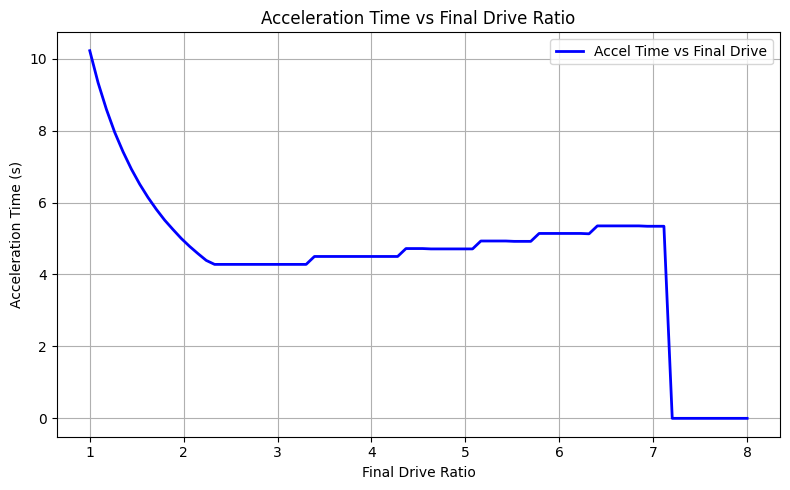

In [21]:
final_drive_sweep = np.linspace(1,8,80)
accel_times = np.zeros_like(final_drive_sweep)
for i, r in enumerate(final_drive_sweep):
    accel_times[i] = accel_run(FD = r)

plt.figure(figsize=(8, 5))
plt.plot(final_drive_sweep, accel_times, label='Accel Time vs Final Drive', color='blue', linewidth=2)

plt.xlabel('Final Drive Ratio')
plt.ylabel('Acceleration Time (s)')
plt.title('Acceleration Time vs Final Drive Ratio')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

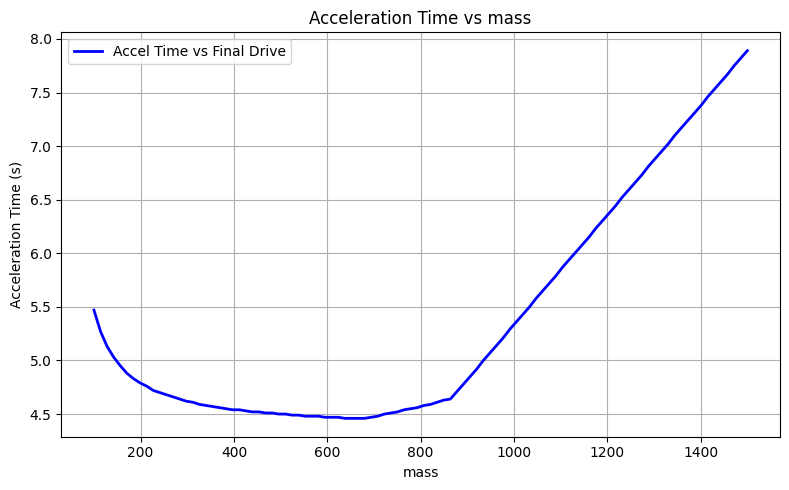

In [20]:
mass_sweep = np.linspace(100,1500,100)
accel_times = np.zeros_like(mass_sweep)
for i, r in enumerate(mass_sweep):
    accel_times[i] = accel_run(M = r)

plt.figure(figsize=(8, 5))
plt.plot(mass_sweep, accel_times, label='Accel Time vs Final Drive', color='blue', linewidth=2)

plt.xlabel('mass')
plt.ylabel('Acceleration Time (s)')
plt.title('Acceleration Time vs mass')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()